#  Identify markers (TF-IDF) and DEGs human germcells celltypes

In [37]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
import scipy
import anndata


sc.set_figure_params(figsize=(4, 4))

In [38]:
def Barplot(which_var, adata, var='clusters', height=3, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
#     ax1.figure.savefig('barplot_'+var+'_proportions_'+which_var+'.pdf', bbox_inches='tight',
#                        dpi=300, orientation='landscape', format= 'pdf', optimize=True)

In [39]:
df = pd.read_csv('stressgenes_vandenBrink2017.csv')
stress_genes = df['gene'].tolist()
stress_genes = [ i.upper() for i in stress_genes]

# Load data

In [40]:
path_to_gonads = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'
adata = sc.read(path_to_gonads + 'FCA-gonads_germcellsClean_annotated.h5ad')

In [41]:
adata.obs['celltype'].values.describe()

,counts,freqs
categories,,
PGC,3764,0.342400
GC_mitotic,510,0.046393
GC,485,0.044119
oogonia_STRA8,2203,0.200400
oogonia_meiotic,1875,0.170563
pre_oocyte,812,0.073865
oocyte,723,0.065769
pre_spermatogonia,621,0.056490


In [42]:
# Remove non confident cells
adata = adata[[ not pd.isna(i) for i in adata.obs.celltype ]]
adata = adata[[i not in ['cont', 'lowQC', 'Doublet'] for i in adata.obs.celltype]]
adata.obs['celltype'].values.describe()

,counts,freqs
categories,,
PGC,3764,0.342400
GC_mitotic,510,0.046393
GC,485,0.044119
oogonia_STRA8,2203,0.200400
oogonia_meiotic,1875,0.170563
pre_oocyte,812,0.073865
oocyte,723,0.065769
pre_spermatogonia,621,0.056490


In [43]:
# Remove stress genes
adata = adata[:,[i not in stress_genes for i in adata.var_names]]

# remove mito genes
non_mito_genes = [name for name in adata.var_names if not name.startswith('MT-')]
adata = adata[:, non_mito_genes]

# remove ribo genes
non_ribo_genes = [name for name in adata.var_names if not name.startswith('RP')]
adata = adata[:, non_ribo_genes]

# remove lowly expressed genes
sc.pp.filter_genes(adata, min_counts=3)

Trying to set attribute `.var` of view, copying.


In [44]:
# move G1 GC_mitotic with GC
mask1 = np.array([i in 'GC_mitotic' for i in adata.obs['celltype']])
mask2 = np.array([i in 'G1' for i in adata.obs['phase']])
mask = [all(tup) for tup in zip(mask1, mask2)]
adata.obs.loc[mask, 'celltype'] = 'GC'

In [45]:
celltype_order = adata.obs.celltype.cat.categories.tolist()
celltype_order

['PGC',
 'GC_mitotic',
 'GC',
 'oogonia_STRA8',
 'oogonia_meiotic',
 'pre_oocyte',
 'oocyte',
 'pre_spermatogonia']

## All germcells celltypes - markers 

In [54]:
import anndata
adataDown = adata.copy()
sc.pp.filter_cells(adataDown, min_genes=1000)
sc.pp.filter_genes(adataDown, min_cells=3)
adataDown.obs['celltype'].value_counts()

PGC                  3406
oogonia_STRA8        1757
oogonia_meiotic      1127
pre_spermatogonia     605
pre_oocyte            519
oocyte                510
GC_mitotic            506
GC                    487
Name: celltype, dtype: int64

In [55]:
#  Downsample to the smallest pop size
target_cells = 320

adataDown.obs['cell'] = adataDown.obs.index
adatas = [adataDown[adataDown.obs['celltype'].isin([cl])] for cl in adataDown.obs['celltype'].cat.categories]

for dat in adatas:
    if dat.n_obs > target_cells:
        sc.pp.subsample(dat, n_obs=target_cells, random_state=0)
adata_downsampled = adatas[0].concatenate(*adatas[1:])
adataDown = adataDown[[ i in adata_downsampled.obs.cell.tolist() for i in adataDown.obs['cell'] ]]

sc.pp.filter_genes(adataDown, min_cells=20)
adataDown.obs['celltype'].value_counts()

Trying to set attribute `.var` of view, copying.


pre_spermatogonia    320
oocyte               320
pre_oocyte           320
oogonia_meiotic      320
oogonia_STRA8        320
GC                   320
GC_mitotic           320
PGC                  320
Name: celltype, dtype: int64

In [56]:
import rpy2.rinterface_lib.callbacks
import logging
# Itoliste R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [57]:
adataDown.X = adataDown.X.toarray()

idx = ['n_genes', 'sample', 'donor', 'location', 'stage', 'sex', 'study', 'batch_collection', 'enrichment', 'cryopreserved', 'TP', '10xKit', 'dig_protocol', 'percent_mito', 'n_counts', 'batch', 'low_ncounts', 'high_mito', 'low_ncounts_high_mito', 'S_score', 'G2M_score', 'phase', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'lineages_v1', 'celltype_v1', 'lineage_v2', 'PCW', 'sample_source', 'trimester', 'lineage',   'leiden', 'leiden_R']
for i in idx:
    del adataDown.obs[i]
    
adataDown.obs['celltype'] = adataDown.obs['celltype'].astype(str)

del adataDown.obsm['X_scVI']
del adataDown.obsm['X_umap']
del adataDown.obsp['connectivities']
del adataDown.obsp['distances']
del adataDown.uns

In [58]:
%%R -i adataDown
adataDown

class: SingleCellExperiment 
dim: 17778 2560 
metadata(0):
assays(1): X
rownames(17778): A1BG A1BG-AS1 ... ZYX ZZEF1
rowData names(224): gene_ids.0 feature_types.0 ... n_counts
  highly_variable_nbatches
colnames(2560): FCA_GND8047885_CGTGAGCTCATCATTC
  FCA_GND8047885_TCCACACAGACTAAGT ... FCA_GND10375780_TTTACTGGTCGCTTTC
  HCA_F_GON10941968_AGCATACAGTGCAAGC
colData names(4): somatic_celltype_v2 celltype_germcellDirty celltype
  cell
reducedDimNames(0):
altExpNames(0):


### TF-IDF

In [59]:
%%R -o df_tfIDF -o topgenes_tfIDF -i celltype_order

library(Seurat)
library(SoupX)
library(dplyr)
seurat_andata = as.Seurat(adataDown, counts = "X", data = "X")
Idents(seurat_andata) = seurat_andata$celltype


df_tfIDF = quickMarkers(toc = seurat_andata@assays$RNA@counts, clusters = Idents(seurat_andata), N = 500)

df_tfIDF$cluster = factor(df_tfIDF$cluster, levels = intersect(celltype_order, seurat_andata$celltype) )
topgenes_tfIDF = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 30L)$gene) %>%
  unlist(.)

In [60]:
df_tfIDF.to_csv(path_to_gonads+'/FCA_germcells_TFIDF.tsv', index=False, sep='\t')

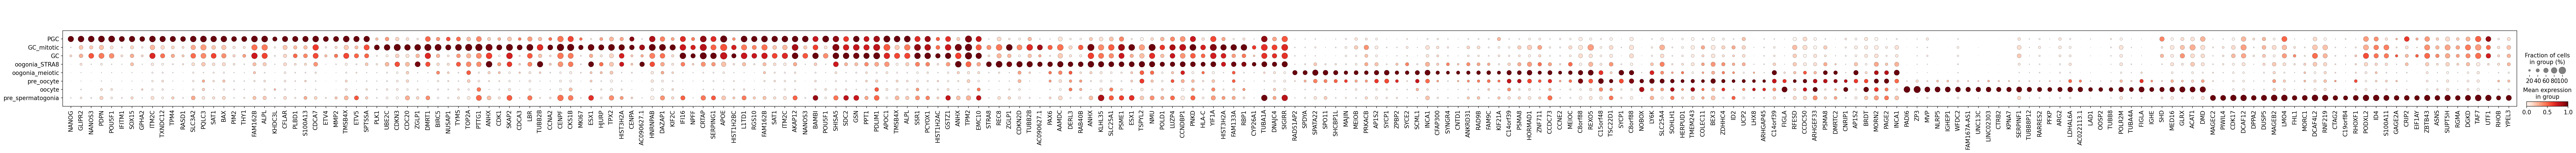

In [61]:
sc.pl.dotplot(adata, list(topgenes_tfIDF), groupby='celltype', standard_scale = 'var', save='_human_germcells_TFIDF.pdf')#topgenes_tfIDF

### DEGs

In [62]:
%%R -o DEGs

library(Seurat)
so = as.Seurat(adataDown, counts = "X", data = "X")
Idents(so) = so$celltype

# Normalize
so <- NormalizeData(so, normalization.method = "LogNormalize", scale.factor = 10000)
so <- ScaleData(so, features = rownames(so))

# Extract DEGs for each cell_type
DEGs <- FindAllMarkers(so, 
                       verbose = F, 
                       only.pos = T, 
                       random.seed = 1, 
                       logfc.threshold = 0, 
                       min.pct = 0, 
                       return.thresh = 1)


In [63]:
DEGs.to_csv(path_to_gonads+'/FCA-gonad_germcells_DEGs.tsv', index=False, sep='\t')

### TF activities - Dorothea

In [64]:
%%R 
source('utils/G_lib_TFacts.r')

Joining, by = "cell"
`summarise()` has grouped output by 'tf'. You can override using the `.groups` argument.
Joining, by = "cell"
`summarise()` has grouped output by 'tf'. You can override using the `.groups` argument.


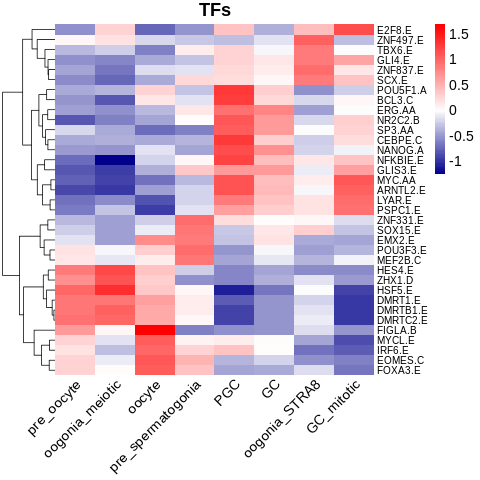

In [65]:
%%R -o df_TFact

# Run Dorothea/viper to get TF activity scores with our custom dorothea_regulon
# Remember "so" should be  normalized
anndataO_doro <- run_viper(so, dorothea_regulon,  options = list(method = "scale", minsize = 4, eset.filter = FALSE, cores = 1, verbose = F))
anndataO_doro

# Get cl x Tf matrix - zscores average
DefaultAssay(object = anndataO_doro) <- "dorothea"
anndataO_doro <- ScaleData(anndataO_doro)
get_TFact_cluster(anndataO_doro, outfile = 'human_germcells_TFact_percluster.csv')


# Use FindAllMarkers to estimate differentially activated TFs
# Make sure you use scaled data
anndataO_doro@assays$dorothea@data = anndataO_doro@assays$dorothea@scale.data
suppressWarnings(df_TFact <- FindAllMarkers(anndataO_doro, verbose = F, 
                                            only.pos = F, random.seed = 1, 
                                            logfc.threshold = 0, min.pct = 0, 
                                            return.thresh = 1,
                                            slot = "data"))
if(is.null(df_TFact$avg_logFC))
    names(df_TFact)[ names(df_TFact) == 'avg_logFC'] = 'avg_logFC'
df_TFact = df_TFact[ order(df_TFact$p_val_adj, decreasing = F),  ]

plot_TFactivities(df_TFact, anndataO_doro, outfile = 'human_germcells_TFact.pdf')

In [66]:
df_TFact.to_csv(path_to_gonads+'/FCA_germcells_TFact.tsv', index=False, sep='\t')

# Sexually dimorphic genes in PGC/GC

## Identify recurrent sexually dimorphic genes 

Unbiased identification of recurrent sexually dimorphic genes by doing DEG analysis in all germcells populations.
We need these genes to removed them as these are non-population specific.

In [23]:
import anndata
adataDown = adata[[ i in ['PGC', 'GC']  for i in adata.obs.celltype ]]

sc.pp.filter_cells(adataDown, min_genes=1000)
adataDown.obs['celltype'].value_counts()

Trying to set attribute `.obs` of view, copying.


PGC    3406
GC      487
Name: celltype, dtype: int64

In [24]:
#  Downsample to the smallest pop size
target_cells = 400

adataDown.obs['cell'] = adataDown.obs.index
adatas = [adataDown[adataDown.obs['celltype'].isin([cl])] for cl in adataDown.obs['celltype'].cat.categories]

for dat in adatas:
    if dat.n_obs > target_cells:
        sc.pp.subsample(dat, n_obs=target_cells, random_state=0)
adata_downsampled = adatas[0].concatenate(*adatas[1:])
adataDown = adataDown[[ i in adata_downsampled.obs.cell.tolist() for i in adataDown.obs['cell'] ]]

sc.pp.filter_genes(adataDown, min_cells=20)

Trying to set attribute `.var` of view, copying.


In [25]:
adataDown.X = adataDown.X.toarray()

idx = ['n_genes', 'sample', 'donor', 'location', 'stage', 'study', 'batch_collection', 'enrichment', 'cryopreserved', 'TP', '10xKit', 'dig_protocol', 'percent_mito', 'n_counts', 'batch', 'low_ncounts', 'high_mito', 'low_ncounts_high_mito', 'S_score', 'G2M_score', 'phase', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'lineages_v1', 'celltype_v1', 'lineage_v2', 'PCW', 'sample_source', 'trimester', 'lineage',   'leiden', 'leiden_R']
for i in idx:
    del adataDown.obs[i]
    
adataDown.obs['celltype'] = adataDown.obs['celltype'].astype(str)

del adataDown.obsm['X_scVI']
del adataDown.obsm['X_umap']
del adataDown.obsp['connectivities']
del adataDown.obsp['distances']
del adataDown.uns

In [26]:
%%R -i adataDown
adataDown

class: SingleCellExperiment 
dim: 13760 800 
metadata(0):
assays(1): X
rownames(13760): A1BG A2M ... ZYX ZZEF1
rowData names(224): gene_ids.0 feature_types.0 ... n_counts
  highly_variable_nbatches
colnames(800): FCA_GND8047885_CGTGAGCTCATCATTC
  FCA_GND8047885_TCCACACAGACTAAGT ...
  HCA_F_GON10941968_AGCATACAGTGCAAGC HCA_F_GON10941969_ACCGTAATCTTCGGTC
colData names(5): sex somatic_celltype_v2 celltype_germcellDirty
  celltype cell
reducedDimNames(0):
altExpNames(0):


In [27]:
%%R -o DEGs

library(Seurat)
so = as.Seurat(adataDown, counts = "X", data = "X")
Idents(so) = so$sex

# Normalize
so <- NormalizeData(so, normalization.method = "LogNormalize", scale.factor = 10000)
so <- ScaleData(so, features = rownames(so))


# Extract DEGs for each cell_type
for (cl in unique(so$celltype) ){
    print(cl)
    so_cl =  subset(so, cells = colnames(so)[ so$celltype == cl ] )
    DEGs <- FindAllMarkers(so_cl, 
                           verbose = F, 
                           only.pos = T, 
                           random.seed = 1, 
                           logfc.threshold = 0.1, 
                           min.pct = 0.1, 
                           return.thresh = 1)
    DEGs = DEGs[ order(DEGs$avg_logFC, decreasing=T) , ]
    write.csv(DEGs, file = paste0('human_sexDim_',cl,'.csv'), quote = F, row.names = F)
}

[1] "PGC"
[1] "GC"


In [28]:
%%R -o sex_genes

sex_genes = list()
for( cl in c('GC', 'PGC') ){
    df = read.csv(paste0('human_sexDim_',cl,'.csv'), stringsAsFactors = F)
    sex_genes[[cl]] = subset(df, p_val_adj < 0.01)$gene
}
sex_genes = Reduce(intersect, sex_genes)
all(c('XIST', 'RPS4Y1', 'EIF1AY', 'DDX3Y', 'GSTM1') %in% sex_genes)
sex_genes

  [1] "GAGE2A"     "EIF1AY"     "GLRX"       "REC8"       "DDX3Y"     
  [6] "TUBB2B"     "MTRNR2L8"   "RUSC1"      "APOA1"      "HOXB5"     
 [11] "GRP"        "HMGB3"      "ANXA2"      "CD81"       "GDPD2"     
 [16] "MTRNR2L12"  "LAS1L"      "KRT19"      "RNASE1"     "IGFBP2"    
 [21] "ID1"        "NLRP7"      "RBP1"       "WIPF3"      "NRP2"      
 [26] "COX7B"      "RGL3"       "PRSS23"     "DPEP3"      "CDK2AP1"   
 [31] "LAGE3"      "UTF1"       "TAF10"      "HOXA7"      "HIST3H2A"  
 [36] "ATRX"       "CITED1"     "AMH"        "CDC34"      "TSPY4"     
 [41] "NMU"        "GSTA1"      "EBP"        "BEX1"       "MEG3"      
 [46] "EMC10"      "CST6"       "TXNDC12"    "TLX2"       "NSG1"      
 [51] "SRM"        "SGK3"       "RARB"       "NENF"       "RAC1"      
 [56] "VGLL4"      "MAG"        "KIF13A"     "ANXA11"     "LAMP1"     
 [61] "CDX1"       "ANHX"       "CHMP4B"     "PTP4A2"     "CRABP1"    
 [66] "MORF4L2"    "BAIAP2L1"   "MAP7D2"     "NDUFA1"     "BRI3"      
 [71] 

## Identify sexually dimorphic genes in GC population

Identify genes that are sexually dimorphic only in the early_supporting population at the time of sex specification

In [29]:
import anndata
adataDown = adata[[ i in ['GC']  for i in adata.obs.celltype ]]

sc.pp.filter_cells(adataDown, min_genes=1000)
adataDown.obs['sex'].value_counts()

Trying to set attribute `.obs` of view, copying.


female    285
male      202
Name: sex, dtype: int64

In [30]:
#  Downsample to the smallest pop size
target_cells = 200

adataDown.obs['cell'] = adataDown.obs.index
adatas = [adataDown[adataDown.obs['sex'].isin([cl])] for cl in adataDown.obs['sex'].cat.categories]

for dat in adatas:
    if dat.n_obs > target_cells:
        sc.pp.subsample(dat, n_obs=target_cells, random_state=0)
adata_downsampled = adatas[0].concatenate(*adatas[1:])
adataDown = adataDown[[ i in adata_downsampled.obs.cell.tolist() for i in adataDown.obs['cell'] ]]

sc.pp.filter_genes(adataDown, min_cells=20)

Trying to set attribute `.var` of view, copying.


In [31]:
adataDown.X = adataDown.X.toarray()

idx = ['n_genes', 'sample', 'donor', 'location', 'stage', 'study', 'batch_collection', 'enrichment', 'cryopreserved', 'TP', '10xKit', 'dig_protocol', 'percent_mito', 'n_counts', 'batch', 'low_ncounts', 'high_mito', 'low_ncounts_high_mito', 'S_score', 'G2M_score', 'phase', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'lineages_v1', 'celltype_v1', 'lineage_v2', 'PCW', 'sample_source', 'trimester', 'lineage',   'leiden', 'leiden_R']
for i in idx:
    del adataDown.obs[i]
    
adataDown.obs['celltype'] = adataDown.obs['celltype'].astype(str)

del adataDown.obsm['X_scVI']
del adataDown.obsm['X_umap']
del adataDown.obsp['connectivities']
del adataDown.obsp['distances']
del adataDown.uns

In [32]:
%%R -i adataDown
adataDown

class: SingleCellExperiment 
dim: 12020 400 
metadata(0):
assays(1): X
rownames(12020): A1BG A2M ... ZYX ZZEF1
rowData names(224): gene_ids.0 feature_types.0 ... n_counts
  highly_variable_nbatches
colnames(400): FCA_GND8125925_GGCGACTCATGTAAGA
  FCA_GND8103050_ACGAGGACATGTAAGA ... FCA_GND10375780_GAAATGAGTTCCCGAG
  FCA_GND10375780_TTAGGCAGTCAGGACA
colData names(5): sex somatic_celltype_v2 celltype_germcellDirty
  celltype cell
reducedDimNames(0):
altExpNames(0):


In [33]:
%%R -o DEGs

library(Seurat)
so = as.Seurat(adataDown, counts = "X", data = "X")
Idents(so) = so$sex

# Normalize
so <- NormalizeData(so, normalization.method = "LogNormalize", scale.factor = 10000)
so <- ScaleData(so, features = rownames(so))

# Extract DEGs for each cell_type
DEGs <- FindAllMarkers(so, 
#                        test.use = 'LR', 
                       verbose = F, 
                       only.pos = T, 
                       random.seed = 1, 
                       logfc.threshold = 0.01, 
                       min.pct = 0.1, 
                       return.thresh = 1)

DEGs = DEGs[ order(DEGs$avg_logFC, decreasing=T) , ]

In [34]:
DEGs.head(20)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
GAGE2A,6.064224e-39,1.817883,0.645,0.025,7.289197e-35,male,GAGE2A
EIF1AY,4.943546e-56,1.309772,0.810,0.000,5.942142e-52,male,EIF1AY
GLRX,1.006091e-39,0.995565,0.835,0.195,1.209322e-35,female,GLRX
REC8,4.342296e-38,0.988338,0.810,0.210,5.219440e-34,female,REC8
DDX3Y,1.543937e-37,0.981934,0.600,0.000,1.855812e-33,male,DDX3Y
TUBB2B,1.695444e-38,0.923712,0.685,0.060,2.037924e-34,female,TUBB2B
MTRNR2L8,8.657540e-10,0.886664,0.280,0.060,1.040636e-05,female,MTRNR2L8
RUSC1,4.322410e-36,0.831980,0.820,0.240,5.195537e-32,female,RUSC1
APOA1,7.318656e-25,0.791781,0.435,0.005,8.797024e-21,male,APOA1
AES,5.709864e-21,0.750343,0.705,0.335,6.863256e-17,male,AES


In [35]:
DEGs.to_csv(path_to_gonads+'/FCA-gonads_germcellsGC_DEGs.tsv', index=False, sep='\t')

In [ ]:
%%R -o DEGs -i path_to_gonads -i sex_genes

sex_genes

library(ggplot2)
library(RColorBrewer)

fe = 'female'
df = DEGs
df = subset(df, ! is.na(gene) )
# df = df[ order(df$avg_logFC, decreasing = T) , ]
DEGs = DEGs[ order(DEGs$p_val_adj, decreasing=F) , ]
df$pctsum = df$pct.1 + df$pct.2
df = subset(df, pctsum < 1.9 )
df$avg_logFC_female = df$avg_logFC
df$avg_logFC_female[ df$cluster == fe ] = -df$avg_logFC[ df$cluster == fe ]
df$log10adjPval = -log10(df$p_val_adj)
df$color = 'grey'
df$color[ df$avg_logFC_female > 0.6 & df$p_val_adj < 0.01] = brewer.pal(n=4, 'Blues')[4]
df$color[ df$avg_logFC_female < -0.6 & df$p_val_adj < 0.01] = brewer.pal(n=4, 'Reds')[4]
n=30
df$label = ''
df$label2 = ''
df$label[ which(df$p_val_adj < 0.01 & abs(df$avg_logFC_female) > 0.6)[1:n] ] = df$gene[ which(df$p_val_adj < 0.01 & abs(df$avg_logFC_female) > 0.6)[1:n] ]
# df$label[ which(df$avg_logFC_female > 0.6 & df$p_val_adj < 0.01)[1:n] ] = df$gene[ which(df$avg_logFC_female > 0.6 & df$p_val_adj < 0.01 )[1:n] ]
# df$label[ which(df$avg_logFC_female < -0.6 & df$p_val_adj < 0.01)[1:n] ] = df$gene[ which(df$avg_logFC_female < -0.6 & df$p_val_adj < 0.01 )[1:n] ]
df$label2[ which( df$label != '' & df$gene %in% sex_genes) ] = df$gene[ which(df$label != '' & df$gene %in% sex_genes)]
df$label[ df$gene %in% sex_genes ] = ''


library(ggrepel)
p = ggplot(df, aes(y=log10adjPval, x=avg_logFC_female, color = color, size = pct.1)) + geom_point(alpha=0.5) + 
    scale_color_identity() + theme_classic(16) +
    geom_text_repel(data=df, aes(label=label2), color = 'grey60', size = 4) + 
    geom_text_repel(data=df, aes(label=label), color = 'black', size = 4) + 
    ggtitle('Sexually dimporhic genes in early_supporting')
p
ggsave(filename = 'human_germcellsGC_volcanoDEGs.pdf', dpi = 75, height = 6, width = 6)
p

# DEGs[which(DEGs$gene %in% c('SRY','ETV5')), ]